### Lab2 (a) Model preperation

In [2]:
from resnet20 import ResNetCIFAR
from train_util import train, finetune, test
import torch
import numpy as np
import matplotlib.pyplot as plt

import time

import torchvision.transforms as transforms
import torchvision
import torch.nn as nn
import torch.optim as optim

from FP_layers import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
net = ResNetCIFAR(num_layers=20, Nbits=None)
net = net.to(device)

In [3]:
# Load the best weight paramters
net.load_state_dict(torch.load("pretrained_model.pt"))
test(net)

Files already downloaded and verified
Test Loss=0.3231, Test accuracy=0.9150


0.915

### Lab2 (b) Prune by percentage

In [4]:
def prune_by_percentage(layer, q):
    """
    Pruning the weight paramters by threshold.
    :param q: pruning percentile. 'q' percent of the least 
    significant weight parameters will be pruned.
    """
    with torch.no_grad():
        # Convert the weight of "layer" to numpy array
        layer_weight = layer.weight.detach().cpu().numpy()
        # Compute the q-th percentile of the abs of the converted array
        percentile = np.percentile(np.abs(layer_weight.flatten()), q)
        # Generate a binary mask same shape as weight to decide which element to prune
        masked_obj = np.ma.masked_greater_equal(x=np.abs(layer_weight), value=percentile, copy=True)
        mask_int = np.ma.getmask(masked_obj).astype(int)
        # Convert mask to torch tensor and put on GPU
        mask_tensor = torch.tensor(mask_int).to(device)
        # Multiply the weight by mask to perform pruning
        assert mask_int.shape == layer_weight.shape
        # layer.weight.data = mask_tensor * layer.weight.data
        layer.weight.data = layer.weight.data.clone().detach().requires_grad_(True) * mask_tensor
    return
    

In [5]:
q_list = np.array([0.3, 0.5, 0.7]) * 100

test_acc_prune_by_perc = []

for q_val in q_list:
    net.load_state_dict(torch.load("pretrained_model.pt"))
    for name, layer in net.named_modules():
        if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
            # change q value
            prune_by_percentage(layer, q=q_val)
            # break
            ## Optional: Check the sparsity you achieve in each layer
            ## Convert the weight of "layer" to numpy array
            np_weight = layer.weight.detach().cpu().numpy()
            ## Count number of zeros
            zeros = sum((np_weight == 0).flatten())
            ## Count number of parameters
            total = len(np_weight.flatten())
            ## Print sparsity
            # print('Sparsity of ' + name + ': '+ str(zeros/total))
            print('Sparsity of %s: %g' % (name, zeros/total))
    test_acc_prune_by_perc.append(test(net))

Sparsity of head_conv.0.conv: 0.300926
Sparsity of body_op.0.conv1.0.conv: 0.299913
Sparsity of body_op.0.conv2.0.conv: 0.299913
Sparsity of body_op.1.conv1.0.conv: 0.299913
Sparsity of body_op.1.conv2.0.conv: 0.299913
Sparsity of body_op.2.conv1.0.conv: 0.299913
Sparsity of body_op.2.conv2.0.conv: 0.299913
Sparsity of body_op.3.conv1.0.conv: 0.30013
Sparsity of body_op.3.conv2.0.conv: 0.300022
Sparsity of body_op.4.conv1.0.conv: 0.300022
Sparsity of body_op.4.conv2.0.conv: 0.300022
Sparsity of body_op.5.conv1.0.conv: 0.300022
Sparsity of body_op.5.conv2.0.conv: 0.300022
Sparsity of body_op.6.conv1.0.conv: 0.300022
Sparsity of body_op.6.conv2.0.conv: 0.299995
Sparsity of body_op.7.conv1.0.conv: 0.299995
Sparsity of body_op.7.conv2.0.conv: 0.299995
Sparsity of body_op.8.conv1.0.conv: 0.299995
Sparsity of body_op.8.conv2.0.conv: 0.299995
Sparsity of final_fc.linear: 0.3
Files already downloaded and verified
Test Loss=0.3699, Test accuracy=0.9027
Sparsity of head_conv.0.conv: 0.5
Sparsity

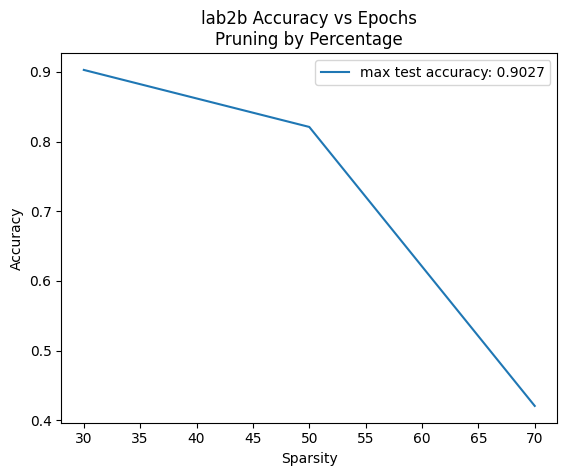

In [6]:
fig, ax = plt.subplots(1, 1)
ax.plot(q_list, test_acc_prune_by_perc, label='max test accuracy: %g' % np.max(test_acc_prune_by_perc))
ax.set_xlabel('Sparsity')
ax.set_ylabel('Accuracy')
ax.set_title('lab2b Accuracy vs Epochs\nPruning by Percentage')
ax.legend()

plt.savefig('lab2b.pdf', dpi=500, bbox_inches='tight')

### Lab2 (c) Finetune pruned model

In [7]:
def finetune_after_prune(net, trainloader, criterion, optimizer, prune=True):
    """
    Finetune the pruned model for a single epoch
    Make sure pruned weights are kept as zero
    """
    # Build a dictionary for the nonzero weights
    weight_mask = {}
    for name, layer in net.named_modules():
        if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
            # Your code here: generate a mask in GPU torch tensor to have 1 for nonzero element and 0 for zero element 
            layer_weight = layer.weight.detach().cpu().numpy()
            mask_obj = np.ma.masked_equal(x=layer_weight, value=0)  # where it's zero, mask value is True
            weight_mask[name] = torch.tensor(1 - np.ma.getmask(mask_obj).astype(int)).to(device)  
            # zero = 0, nonzero = 1
    
    global_steps = 0
    train_loss = 0
    correct = 0
    total = 0
    start = time.time()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        if prune:
            for name,layer in net.named_modules():
                if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
                    # Your code here: Use weight_mask to make sure zero elements remains zero                    
                    layer.weight.data = layer.weight.data.clone().detach().requires_grad_(True) * weight_mask[name]
                    
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        global_steps += 1

        if global_steps % 50 == 0:
            end = time.time()
            batch_size = 256
            num_examples_per_second = 50 * batch_size / (end - start)
            print("[Step=%d]\tLoss=%.4f\tacc=%.4f\t%.1f examples/second"
                 % (global_steps, train_loss / (batch_idx + 1), (correct / total), num_examples_per_second))
            start = time.time()

In [8]:
# Get pruned model
net.load_state_dict(torch.load("pretrained_model.pt"))
for name, layer in net.named_modules():
    if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
        prune_by_percentage(layer, q=70.0)
lab2c_test_b4_finetune = test(net)
# Training setup, do not change
batch_size = 256
lr = 0.002
reg = 1e-4

print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=16)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.875, weight_decay=reg, nesterov=False)

Files already downloaded and verified
Test Loss=2.4418, Test accuracy=0.4207
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [9]:
# Model finetuning
test_acc_lst = []
n_epochs = 20
for epoch in range(n_epochs):
    print('\nEpoch: %d' % epoch)
    net.train()
    finetune_after_prune(net, trainloader, criterion, optimizer)
    #Start the testing code.
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    num_val_steps = len(testloader)
    val_acc = correct / total
    print("Test Loss=%.4f, Test acc=%.4f" % (test_loss / (num_val_steps), val_acc))
    test_acc_lst.append(val_acc)
    if val_acc > best_acc:
        best_acc = val_acc
        print("Saving...")
        torch.save(net.state_dict(), "net_after_finetune.pt")


Epoch: 0
[Step=50]	Loss=0.4015	acc=0.8612	6063.1 examples/second
[Step=100]	Loss=0.3621	acc=0.8752	12533.4 examples/second
[Step=150]	Loss=0.3334	acc=0.8853	12582.2 examples/second
Test Loss=0.4290, Test acc=0.8676
Saving...

Epoch: 1
[Step=50]	Loss=0.2458	acc=0.9155	6556.5 examples/second
[Step=100]	Loss=0.2449	acc=0.9152	12105.4 examples/second
[Step=150]	Loss=0.2388	acc=0.9171	12214.2 examples/second
Test Loss=0.3941, Test acc=0.8752
Saving...

Epoch: 2
[Step=50]	Loss=0.2220	acc=0.9273	6774.9 examples/second
[Step=100]	Loss=0.2218	acc=0.9254	12616.7 examples/second
[Step=150]	Loss=0.2150	acc=0.9276	12099.2 examples/second
Test Loss=0.3787, Test acc=0.8789
Saving...

Epoch: 3
[Step=50]	Loss=0.1934	acc=0.9318	6663.5 examples/second
[Step=100]	Loss=0.2036	acc=0.9284	12776.3 examples/second
[Step=150]	Loss=0.2007	acc=0.9292	12756.8 examples/second
Test Loss=0.3710, Test acc=0.8813
Saving...

Epoch: 4
[Step=50]	Loss=0.1908	acc=0.9345	6193.6 examples/second
[Step=100]	Loss=0.1856	acc=0.9

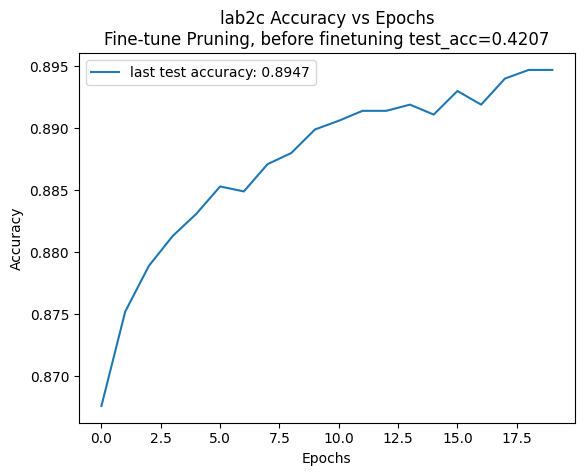

In [10]:
fig, ax = plt.subplots(1, 1)
xx = range(n_epochs)
ax.plot(xx, test_acc_lst, label='last test accuracy: %g' % test_acc_lst[-1])
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('lab2c Accuracy vs Epochs\nFine-tune Pruning, before finetuning test_acc=%.4f' 
             % lab2c_test_b4_finetune)
ax.legend()

plt.savefig('Figures/lab2c.pdf', dpi=500, bbox_inches='tight')

In [11]:
# Check sparsity of the finetuned model, make sure it's not changed
net.load_state_dict(torch.load("net_after_finetune.pt"))

for name,layer in net.named_modules():
    if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
        # Your code here:
        ## Convert the weight of "layer" to numpy array
        np_weight = layer.weight.detach().cpu().numpy()
        ## Count number of zeros
        zeros = sum((np_weight == 0).flatten())
        ## Count number of parameters
        total = len(np_weight.flatten())
        # Print sparsity
        print('Sparsity of %s: %g' % (name, zeros/total))   
        
test(net)

Sparsity of head_conv.0.conv: 0.699074
Sparsity of body_op.0.conv1.0.conv: 0.700087
Sparsity of body_op.0.conv2.0.conv: 0.700087
Sparsity of body_op.1.conv1.0.conv: 0.700087
Sparsity of body_op.1.conv2.0.conv: 0.700087
Sparsity of body_op.2.conv1.0.conv: 0.700087
Sparsity of body_op.2.conv2.0.conv: 0.700087
Sparsity of body_op.3.conv1.0.conv: 0.69987
Sparsity of body_op.3.conv2.0.conv: 0.699978
Sparsity of body_op.4.conv1.0.conv: 0.699978
Sparsity of body_op.4.conv2.0.conv: 0.699978
Sparsity of body_op.5.conv1.0.conv: 0.699978
Sparsity of body_op.5.conv2.0.conv: 0.699978
Sparsity of body_op.6.conv1.0.conv: 0.699978
Sparsity of body_op.6.conv2.0.conv: 0.700005
Sparsity of body_op.7.conv1.0.conv: 0.700005
Sparsity of body_op.7.conv2.0.conv: 0.700005
Sparsity of body_op.8.conv1.0.conv: 0.700005
Sparsity of body_op.8.conv2.0.conv: 0.700005
Sparsity of final_fc.linear: 0.7
Files already downloaded and verified
Test Loss=0.3343, Test accuracy=0.8947


0.8947

### Lab2 (d) Iterative pruning

In [12]:
net.load_state_dict(torch.load("pretrained_model.pt"))
best_acc = 0.
n_epochs = 20

test_acc_iter_prune = []

for epoch in range(n_epochs):
    print('\nEpoch: %d' % epoch)
    
    net.train()
    if epoch < 10:
        for name,layer in net.named_modules():
            if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
                # Increase model sparsity
                q = (epoch + 1) * 7
                # Linearly increase the pruning percentage for 10 epochs until reaching 70% in the final epoch
                prune_by_percentage(layer, q=q)
    if epoch < 9:
        finetune_after_prune(net, trainloader, criterion, optimizer, prune=False)
    else: # starts from epoch==9, where q = 70%
        finetune_after_prune(net, trainloader, criterion, optimizer)
    
    #Start the testing code.
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    num_val_steps = len(testloader)
    val_acc = correct / total
    
    test_acc_iter_prune.append(val_acc)
        
    print("Test Loss=%.4f, Test acc=%.4f" % (test_loss / (num_val_steps), val_acc))
    
    if epoch>=10:
        if val_acc > best_acc:
            best_acc = val_acc
            print("Saving...")
            torch.save(net.state_dict(), "net_after_iterative_prune.pt")


Epoch: 0
[Step=50]	Loss=0.0472	acc=0.9847	6590.0 examples/second
[Step=100]	Loss=0.0482	acc=0.9841	12078.6 examples/second
[Step=150]	Loss=0.0481	acc=0.9843	12069.6 examples/second
Test Loss=0.3262, Test acc=0.9134

Epoch: 1
[Step=50]	Loss=0.0482	acc=0.9840	6651.5 examples/second
[Step=100]	Loss=0.0497	acc=0.9833	12706.2 examples/second
[Step=150]	Loss=0.0481	acc=0.9841	12666.0 examples/second
Test Loss=0.3265, Test acc=0.9139

Epoch: 2
[Step=50]	Loss=0.0475	acc=0.9846	6783.0 examples/second
[Step=100]	Loss=0.0507	acc=0.9833	12782.9 examples/second
[Step=150]	Loss=0.0497	acc=0.9841	12842.8 examples/second
Test Loss=0.3286, Test acc=0.9148

Epoch: 3
[Step=50]	Loss=0.0521	acc=0.9824	5565.0 examples/second
[Step=100]	Loss=0.0516	acc=0.9832	11161.7 examples/second
[Step=150]	Loss=0.0525	acc=0.9824	12087.6 examples/second
Test Loss=0.3304, Test acc=0.9125

Epoch: 4
[Step=50]	Loss=0.0631	acc=0.9784	6435.7 examples/second
[Step=100]	Loss=0.0618	acc=0.9793	12608.6 examples/second
[Step=150]	L

In [13]:
# Check sparsity of the final model, make sure it's 70%
net.load_state_dict(torch.load("net_after_iterative_prune.pt"))

for name,layer in net.named_modules():
    if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
        # Your code here: can copy from previous question
        ## Convert the weight of "layer" to numpy array
        np_weight = layer.weight.detach().cpu().numpy()
        ## Count number of zeros
        zeros = sum((np_weight == 0).flatten())
        ## Count number of parameters
        total = len(np_weight.flatten())
        # Print sparsity
        print('Sparsity of %s: %g' % (name, zeros/total))   
        
        
test(net)

Sparsity of head_conv.0.conv: 0.699074
Sparsity of body_op.0.conv1.0.conv: 0.700087
Sparsity of body_op.0.conv2.0.conv: 0.700087
Sparsity of body_op.1.conv1.0.conv: 0.700087
Sparsity of body_op.1.conv2.0.conv: 0.700087
Sparsity of body_op.2.conv1.0.conv: 0.700087
Sparsity of body_op.2.conv2.0.conv: 0.700087
Sparsity of body_op.3.conv1.0.conv: 0.69987
Sparsity of body_op.3.conv2.0.conv: 0.699978
Sparsity of body_op.4.conv1.0.conv: 0.699978
Sparsity of body_op.4.conv2.0.conv: 0.699978
Sparsity of body_op.5.conv1.0.conv: 0.699978
Sparsity of body_op.5.conv2.0.conv: 0.699978
Sparsity of body_op.6.conv1.0.conv: 0.699978
Sparsity of body_op.6.conv2.0.conv: 0.700005
Sparsity of body_op.7.conv1.0.conv: 0.700005
Sparsity of body_op.7.conv2.0.conv: 0.700005
Sparsity of body_op.8.conv1.0.conv: 0.700005
Sparsity of body_op.8.conv2.0.conv: 0.700005
Sparsity of final_fc.linear: 0.7
Files already downloaded and verified
Test Loss=0.3405, Test accuracy=0.8922


0.8922

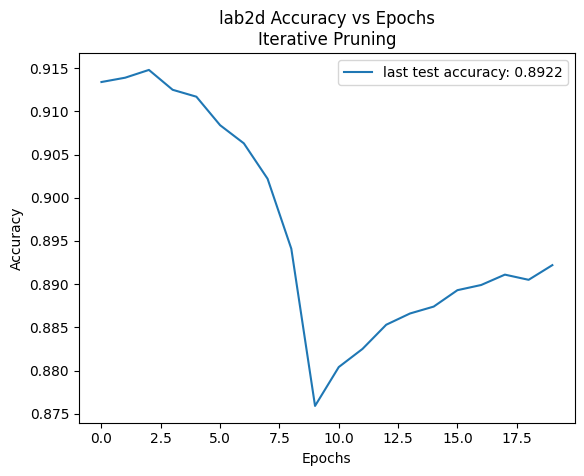

In [14]:
fig, ax = plt.subplots(1, 1)
xx = range(n_epochs)
ax.plot(xx, test_acc_iter_prune, label='last test accuracy: %g' % test_acc_iter_prune[-1])
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('lab2d Accuracy vs Epochs\nIterative Pruning')
ax.legend()

plt.savefig('Figures/lab2d.pdf', dpi=500, bbox_inches='tight')

### Lab2 (e) Global iterative pruning

In [15]:
import numpy as np

def global_prune_by_percentage(net, q=70.0):
    """
    Pruning the weight paramters by threshold.
    :param q: pruning percentile. 'q' percent of the least 
    significant weight parameters will be pruned.
    """
    # A list to gather all the weights
    flattened_weights = []
    # Find global pruning threshold
    for name,layer in net.named_modules():
        if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
            # Convert weight to numpy
            # Flatten the weight and append to flattened_weights
            flattened_weights.append(layer.weight.detach().cpu().numpy().flatten())
    
    # Concate all weights into a np array
    flattened_weights = np.concatenate(flattened_weights)
    # Find global pruning threshold
    threshold = np.percentile(np.abs(flattened_weights.flatten()), q)
    
    # Apply pruning threshold to all layers
    for name,layer in net.named_modules():
        if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
            # Convert weight to numpy
            layer_weight = layer.weight.detach().cpu().numpy()
            
            # Generate a binary mask same shape as weight to decide which element to prune
            masked_obj = np.ma.masked_greater_equal(x=np.abs(layer_weight), value=threshold, copy=True)
            mask_int = np.ma.getmask(masked_obj).astype(int)
            # Convert mask to torch tensor and put on GPU
            mask_tensor = torch.tensor(mask_int).to(device)
            # Multiply the weight by mask to perform pruning
            layer.weight.data = layer.weight.data.clone().detach().requires_grad_(True) * mask_tensor

In [16]:
net.load_state_dict(torch.load("pretrained_model.pt"))
best_acc = 0.

test_acc_global_prune = []

for epoch in range(20):
    print('\nEpoch: %d' % epoch)
    # q = (epoch + 1) * 8
    q = (epoch + 1) * 7
    
    net.train()
    # Increase model sparsity
    if epoch < 10:
        global_prune_by_percentage(net, q=q)
    if epoch < 9:
        finetune_after_prune(net, trainloader, criterion, optimizer, prune=False)
    else:
        finetune_after_prune(net, trainloader, criterion, optimizer)
    
    #Start the testing code.
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    num_val_steps = len(testloader)
    val_acc = correct / total
    print("Test Loss=%.4f, Test acc=%.4f" % (test_loss / (num_val_steps), val_acc))
    
    test_acc_global_prune.append(val_acc)
    
    if epoch >= 10:
        if val_acc > best_acc:
            best_acc = val_acc
            print("Saving...")
            torch.save(net.state_dict(), "net_after_global_iterative_prune.pt")


Epoch: 0
[Step=50]	Loss=0.0494	acc=0.9846	6143.9 examples/second
[Step=100]	Loss=0.0484	acc=0.9847	12491.2 examples/second
[Step=150]	Loss=0.0493	acc=0.9843	12542.2 examples/second
Test Loss=0.3235, Test acc=0.9150

Epoch: 1
[Step=50]	Loss=0.0483	acc=0.9848	6045.3 examples/second
[Step=100]	Loss=0.0488	acc=0.9844	12603.3 examples/second
[Step=150]	Loss=0.0488	acc=0.9844	10154.3 examples/second
Test Loss=0.3239, Test acc=0.9143

Epoch: 2
[Step=50]	Loss=0.0480	acc=0.9859	5200.7 examples/second
[Step=100]	Loss=0.0480	acc=0.9857	12315.7 examples/second
[Step=150]	Loss=0.0483	acc=0.9854	12389.8 examples/second
Test Loss=0.3291, Test acc=0.9137

Epoch: 3
[Step=50]	Loss=0.0501	acc=0.9843	6317.4 examples/second
[Step=100]	Loss=0.0496	acc=0.9845	12250.7 examples/second
[Step=150]	Loss=0.0499	acc=0.9841	12418.7 examples/second
Test Loss=0.3274, Test acc=0.9127

Epoch: 4
[Step=50]	Loss=0.0500	acc=0.9841	4792.6 examples/second
[Step=100]	Loss=0.0519	acc=0.9842	12345.4 examples/second
[Step=150]	L

In [7]:
net.load_state_dict(torch.load("net_after_global_iterative_prune.pt"))
sparsity_list = []
x_ticks_labels = []
zeros_sum = 0
total_sum = 0
for name, layer in net.named_modules():
    if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
        # Your code here:
        # Convert the weight of "layer" to numpy array
        np_weight = layer.weight.detach().cpu().numpy()
        # Count number of zeros
        zeros = sum((np_weight == 0).flatten())
        # Count number of parameters
        total = len(np_weight.flatten())
        zeros_sum += zeros
        total_sum += total
        sparsity_list.append(zeros / (total / 1.0))
        x_ticks_labels.append(name)
        print('Sparsity of %s: %g' % (name, zeros / (total / 1.0)))   
print('Total sparsity: %g' % (zeros_sum / (total_sum / 1.0)))
test(net)

Sparsity of head_conv.0.conv: 0.240741
Sparsity of body_op.0.conv1.0.conv: 0.550781
Sparsity of body_op.0.conv2.0.conv: 0.528646
Sparsity of body_op.1.conv1.0.conv: 0.518663
Sparsity of body_op.1.conv2.0.conv: 0.552517
Sparsity of body_op.2.conv1.0.conv: 0.516493
Sparsity of body_op.2.conv2.0.conv: 0.565104
Sparsity of body_op.3.conv1.0.conv: 0.52474
Sparsity of body_op.3.conv2.0.conv: 0.583008
Sparsity of body_op.4.conv1.0.conv: 0.615343
Sparsity of body_op.4.conv2.0.conv: 0.677409
Sparsity of body_op.5.conv1.0.conv: 0.611654
Sparsity of body_op.5.conv2.0.conv: 0.702799
Sparsity of body_op.6.conv1.0.conv: 0.615343
Sparsity of body_op.6.conv2.0.conv: 0.651232
Sparsity of body_op.7.conv1.0.conv: 0.662137
Sparsity of body_op.7.conv2.0.conv: 0.718777
Sparsity of body_op.8.conv1.0.conv: 0.74821
Sparsity of body_op.8.conv2.0.conv: 0.937283
Sparsity of final_fc.linear: 0.11875
Total sparsity: 0.699999
Files already downloaded and verified
Test Loss=0.3182, Test accuracy=0.8986


0.8986

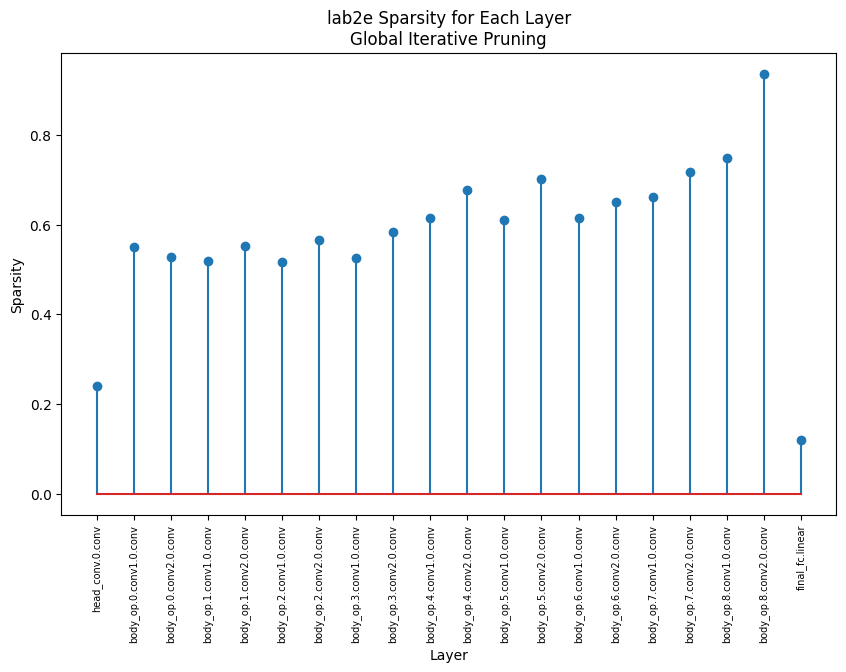

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
xx = range(len(sparsity_list))
ax.stem(xx, sparsity_list)
ax.set_xticks(range(len(xx)), x_ticks_labels, rotation='vertical', fontsize=7)
ax.set_xlabel('Layer')
ax.set_ylabel('Sparsity')
ax.set_title('lab2e Sparsity for Each Layer\nGlobal Iterative Pruning')

plt.savefig('Figures/lab2e_sparsity.pdf', dpi=500, bbox_inches='tight')

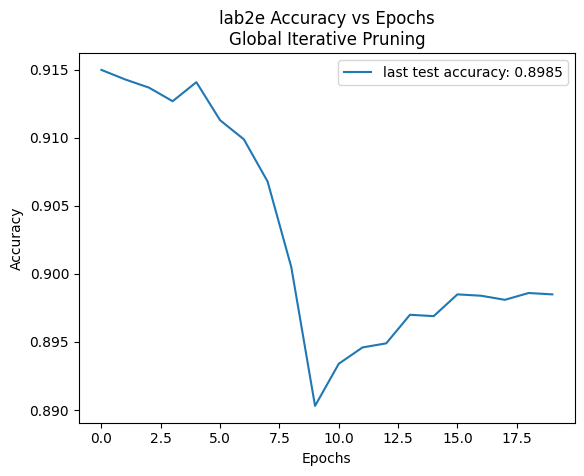

In [18]:
fig, ax = plt.subplots(1, 1)
xx = range(n_epochs)
ax.plot(xx, test_acc_global_prune, label='last test accuracy: %g' % test_acc_global_prune[-1])
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('lab2e Accuracy vs Epochs\nGlobal Iterative Pruning')
ax.legend()

plt.savefig('Figures/lab2e.pdf', dpi=500, bbox_inches='tight')

### Lab 3 (b) and (c): Fixed-point quantization

In [4]:
# load pretrained ResNet-20 model, report the accuracy of the floating-point pretrained model.
net = ResNetCIFAR(num_layers=20)
net = net.to(device)
net.load_state_dict(torch.load("pretrained_model.pt"))
print("before quantisation:")
test(net)
print()

# Define quantized model and load weight
Nbits_arr = [2, 3, 4, 5, 6]
test_acc_lab3b = []
for iii, nb in enumerate(Nbits_arr):
    Nbits = nb #Change this value to finish (b) and (c)

    net = ResNetCIFAR(num_layers=20, Nbits=Nbits)
    net = net.to(device)
    net.load_state_dict(torch.load("pretrained_model.pt"))
    test_acc_lab3b.append(test(net))

before quantisation:
Files already downloaded and verified
Test Loss=0.3231, Test accuracy=0.9150

Files already downloaded and verified
Test Loss=9.6086, Test accuracy=0.0906
Files already downloaded and verified
Test Loss=0.9857, Test accuracy=0.7665
Files already downloaded and verified
Test Loss=0.3860, Test accuracy=0.8973
Files already downloaded and verified
Test Loss=0.3391, Test accuracy=0.9113
Files already downloaded and verified
Test Loss=0.3364, Test accuracy=0.9144


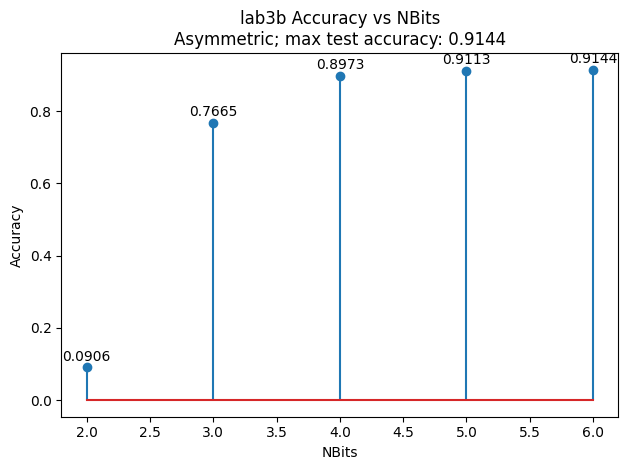

In [10]:
fig, ax = plt.subplots(1, 1)
xx = Nbits_arr
ax.stem(xx, test_acc_lab3b)
# ax.plot(xx, test_acc_lab3b, label='max test accuracy: %g' % np.max(test_acc_lab3b))
ax.set_xlabel('NBits')
ax.set_ylabel('Accuracy')
ax.set_title('lab3b Accuracy vs NBits\nAsymmetric; max test accuracy: %g' % np.max(test_acc_lab3b))
for (x, y) in zip(xx, test_acc_lab3b):
    plt.annotate('{:.4f}'.format(y), xy=(x, y), xytext=(0, 5), textcoords='offset points',ha='center')
fig.tight_layout()
plt.savefig('Figures/lab3b.pdf', dpi=500, bbox_inches='tight')

In [11]:
# lab 3 part c is shown below:

In [12]:
Nbits_arr_c = [2, 3, 4]
test_acc_lab3c_finetune = {}  
# test accuracy for each finetuning as fn of epoch 
final_test_acc_lab3c = {}  # test acc after finetuning for each Nbit
n_epochs = 20
test_acc_lab3c_b4_finetune = {} # test acc before finetuning

for iii, nb in enumerate(Nbits_arr_c):
    # Define quantized model and load weight
    Nbits = nb #Change this value to finish (b) and (c)

    net = ResNetCIFAR(num_layers=20, Nbits=Nbits)
    net = net.to(device)
    net.load_state_dict(torch.load("pretrained_model.pt"))
    test_acc_lab3c_b4_finetune[Nbits] = test(net)

    # Quantized model finetuning
    test_acc_lab3c_finetune[Nbits] = np.asarray(
        finetune(net, epochs=n_epochs, batch_size=256, lr=0.002, reg=1e-4)) 
    # finetune() supposedly returns list of val_accuracy values
    # Load the model with best accuracy
    net.load_state_dict(torch.load("quantized_net_after_finetune.pt"))
    final_test_acc_lab3c[Nbits] = test(net)

Files already downloaded and verified
Test Loss=9.6086, Test accuracy=0.0906
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified

Epoch: 0
[Step=50]	Loss=1.3199	acc=0.6250	5064.9 examples/second
[Step=100]	Loss=1.0535	acc=0.6870	9559.5 examples/second
[Step=150]	Loss=0.9346	acc=0.7166	9594.5 examples/second
Test Loss=0.7387, Test acc=0.7820
Saving...

Epoch: 1
[Step=200]	Loss=0.6141	acc=0.8047	3416.9 examples/second
[Step=250]	Loss=0.5912	acc=0.8040	9611.2 examples/second
[Step=300]	Loss=0.5688	acc=0.8098	9720.0 examples/second
[Step=350]	Loss=0.5459	acc=0.8157	9729.8 examples/second
Test Loss=0.6160, Test acc=0.8087
Saving...

Epoch: 2
[Step=400]	Loss=0.4761	acc=0.8359	2916.8 examples/second
[Step=450]	Loss=0.4810	acc=0.8365	8614.2 examples/second
[Step=500]	Loss=0.4718	acc=0.8390	7992.3 examples/second
[Step=550]	Loss=0.4650	acc=0.8406	9019.1 examples/second
Test Loss=0.5682, Test acc=0.8207
Saving...

Epoch: 3
[Step=600]	Loss=0.4422	acc=0

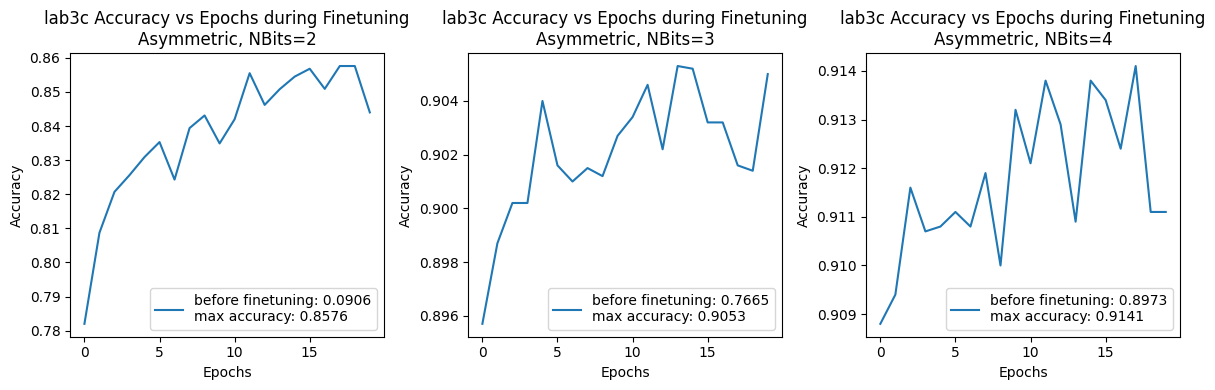

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

for iii, nbits in enumerate(Nbits_arr_c):
    xx = range(n_epochs)
    ax[iii].plot(xx, test_acc_lab3c_finetune[nbits], label='before finetuning: %g\nmax accuracy: %g'
                 % (test_acc_lab3c_b4_finetune[nbits], np.max(test_acc_lab3c_finetune[nbits])))
    ax[iii].set_xlabel('Epochs')
    ax[iii].set_ylabel('Accuracy')
    ax[iii].set_title('lab3c Accuracy vs Epochs during Finetuning\nAsymmetric, NBits=%d' % nbits)
    ax[iii].legend()
fig.tight_layout()
plt.savefig('Figures/lab3c.pdf', dpi=500, bbox_inches='tight')

### Lab3 (d) Quantize pruned model

In [2]:
nbits_lab3d = [2, 3, 4]
test_acc_lab3d_b4_finetune = {}
test_acc_arrays_finetune = {}
test_acc_lab3d_after_finetune = {}
n_epochs = 20

for iii, nb in enumerate(nbits_lab3d):
    # Define quantized model and load weight
    Nbits = nb #Change this value to finish (d)

    net = ResNetCIFAR(num_layers=20, Nbits=Nbits)
    net = net.to(device)
    net.load_state_dict(torch.load("net_after_global_iterative_prune.pt"))
    test_acc_lab3d_b4_finetune[Nbits] = test(net)

    # Quantized model finetuning
    test_acc_arrays_finetune[Nbits] = np.array(
        finetune(net, epochs=n_epochs, batch_size=256, lr=0.002, reg=1e-4))

    # Do not load the model with best accuracy since we want the last acc value.
    # net.load_state_dict(torch.load("quantized_net_after_finetune.pt"))
    test_acc_lab3d_after_finetune[Nbits] = test(net)

Files already downloaded and verified
Test Loss=8523.9728, Test accuracy=0.1000
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified

Epoch: 0
[Step=50]	Loss=2.2584	acc=0.1487	2551.6 examples/second
[Step=100]	Loss=2.2225	acc=0.1541	4022.4 examples/second
[Step=150]	Loss=2.2040	acc=0.1603	2889.7 examples/second
Test Loss=2.1456, Test acc=0.1768
Saving...

Epoch: 1
[Step=200]	Loss=2.1437	acc=0.1777	1498.7 examples/second
[Step=250]	Loss=2.1324	acc=0.1859	5755.3 examples/second
[Step=300]	Loss=2.1203	acc=0.1960	7315.4 examples/second
[Step=350]	Loss=2.1173	acc=0.2018	6008.7 examples/second
Test Loss=2.0912, Test acc=0.2219
Saving...

Epoch: 2
[Step=400]	Loss=2.0949	acc=0.2173	2328.7 examples/second
[Step=450]	Loss=2.0796	acc=0.2308	7142.5 examples/second
[Step=500]	Loss=2.0751	acc=0.2343	6791.7 examples/second
[Step=550]	Loss=2.0707	acc=0.2361	5729.8 examples/second
Test Loss=2.0630, Test acc=0.2419
Saving...

Epoch: 3
[Step=600]	Loss=2.0576	ac

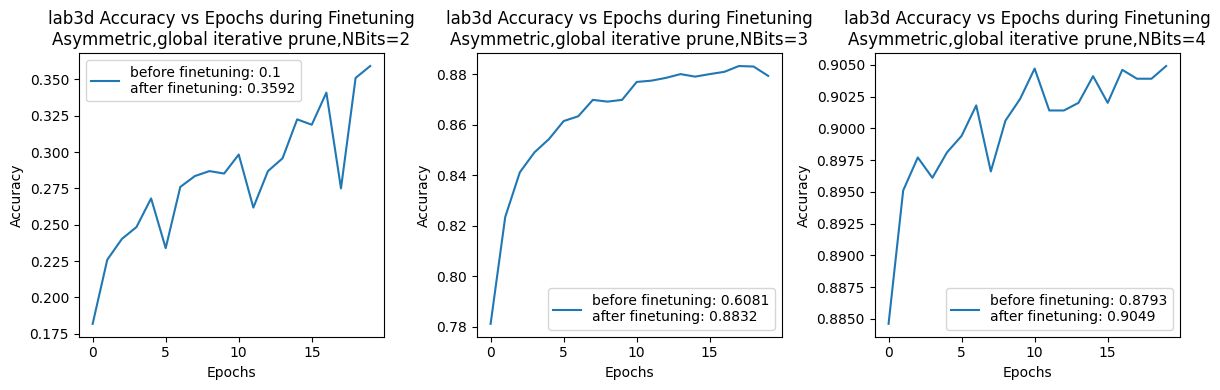

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

for iii, nbits in enumerate(nbits_lab3d):
    xx = range(n_epochs)
    ax[iii].plot(xx, test_acc_arrays_finetune[nbits], label='before finetuning: %g\nafter finetuning: %g' 
                 % (test_acc_lab3d_b4_finetune[nbits], test_acc_lab3d_after_finetune[nbits]))
    ax[iii].set_xlabel('Epochs')
    ax[iii].set_ylabel('Accuracy')
    ax[iii].set_title('lab3d Accuracy vs Epochs during Finetuning\n'
                      'Asymmetric,global iterative prune,NBits=%d' % nbits)
    ax[iii].legend()
fig.tight_layout()
plt.savefig('Figures/lab3d.pdf', dpi=500, bbox_inches='tight')

### Lab3 (e) Symmetric quantization
#### Implement symmetric quantization in FP_layers.py, and repeat the process in (b)

In [2]:
# check the performance of symmetric quantization with 6, 5, 4, 3, 2 bits
# Define quantized model and load weight
Nbits_arr_lab3e = [2, 3, 4, 5, 6]
test_acc_lab3e = []
for iii, nb in enumerate(Nbits_arr_lab3e):
    Nbits = nb #Change this value

    net = ResNetCIFAR(num_layers=20, Nbits=Nbits, symmetric=True)  # symmetric
    net = net.to(device)
    net.load_state_dict(torch.load("pretrained_model.pt"))
    test_acc_lab3e.append(test(net))

Files already downloaded and verified
Test Loss=42.7983, Test accuracy=0.1000
Files already downloaded and verified
Test Loss=2.3751, Test accuracy=0.5186
Files already downloaded and verified
Test Loss=0.4227, Test accuracy=0.8875
Files already downloaded and verified
Test Loss=0.3518, Test accuracy=0.9081
Files already downloaded and verified
Test Loss=0.3276, Test accuracy=0.9124


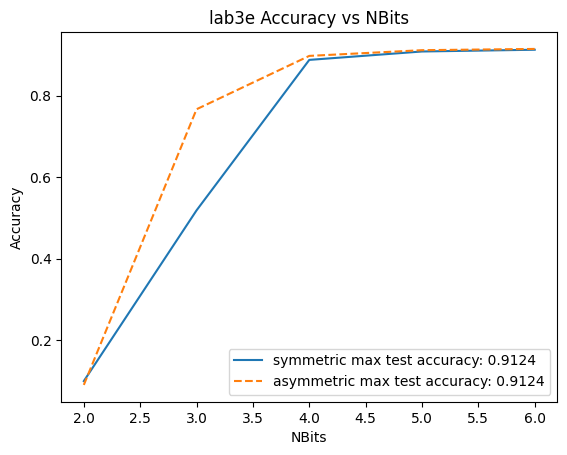

In [5]:
fig, ax = plt.subplots(1, 1)
xx = Nbits_arr_lab3e
ax.plot(xx, test_acc_lab3e, label='symmetric max test accuracy: %g' % np.max(test_acc_lab3e))
ax.plot(xx, test_acc_lab3b, '--', label='asymmetric max test accuracy: %g' % np.max(test_acc_lab3e))
ax.set_xlabel('NBits')
ax.set_ylabel('Accuracy')
ax.set_title('lab3e Accuracy vs NBits')
ax.legend()

plt.savefig('Figures/lab3e.pdf', dpi=500, bbox_inches='tight')

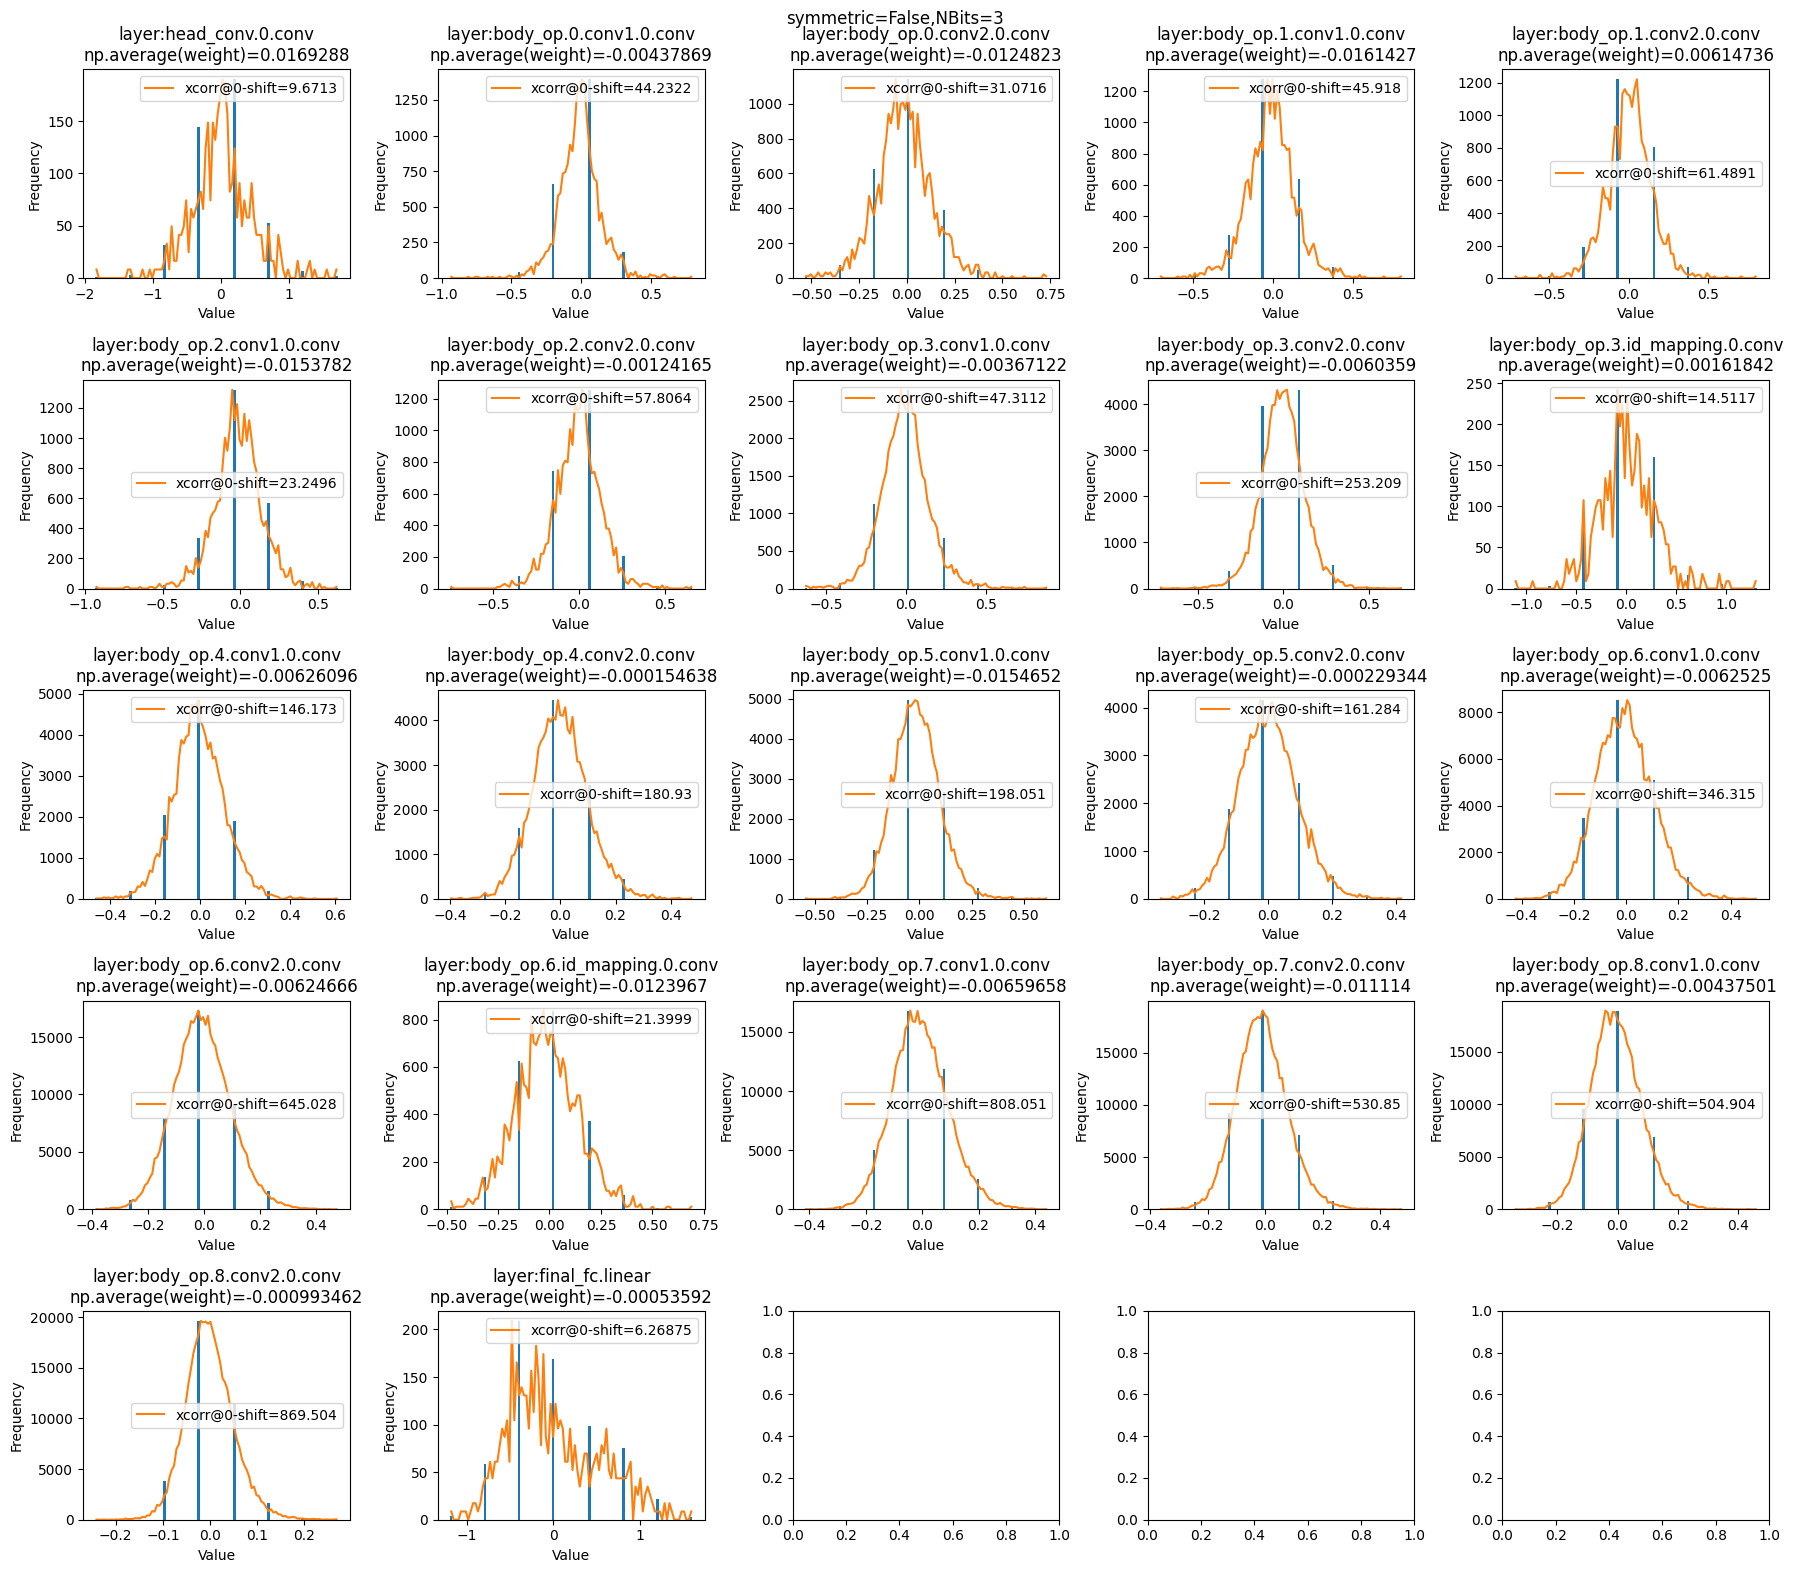

In [11]:
def plot_quant_symmetry(symmetric, NBits=3, bins=100, save=False):

    net = ResNetCIFAR(num_layers=20) # this is for original weights
    net = net.to(device)
    net.load_state_dict(torch.load("pretrained_model.pt"))
    weights_dict_quant = {}
    w_dict_orig = {}
    conv_list = []
    for name, module in net.named_modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            w_dict_orig[str(name)] = module.weight.detach().cpu().numpy().flatten()
            www = STE().forward(ctx=None, w=module.weight, bit=NBits, symmetric=symmetric)
            np_weights = www.cpu().detach().numpy()
            weights_dict_quant[str(name)] = np_weights.flatten()
    # print(len(weights_dict_quant.keys()))
    # print(weights_dict_quant.keys())
    fig, ax = plt.subplots(5, 5, figsize=(18, 16))
    ax_flat = ax.flatten()
    for iii, layer_name in enumerate(list(weights_dict_quant.keys())):
        y_val, edges = np.histogram(w_dict_orig[layer_name], bins=bins)
        x_val = np.convolve(edges, [0.5, 0.5])[1:-1]  # compute average btw adjacent elements of edges
        
        y_val_quant, _ = np.histogram(weights_dict_quant[layer_name], bins=bins)
        ax_flat[iii].hist(weights_dict_quant[layer_name], bins=bins)
        ax_flat[iii].set_title(str("layer:%s\nnp.average(weight)=%g" % 
                                   (layer_name, np.average(weights_dict_quant[layer_name]))))
        ax_flat[iii].set_xlabel('Value')
        ax_flat[iii].set_ylabel('Frequency')
        conv = np.convolve(y_val_quant, y_val, 'valid')
        # if len(conv) % 2 == 0:
            # zeroshift_convolve = 0.5*(conv[int((len(conv)-1)/2)] + conv[int((len(conv)+1)/2)]) \
            # / len(weights_dict_quant[layer_name])
        # else:
            # zeroshift_convolve = (conv[int(len(conv)/2)]) / len(weights_dict_quant[layer_name])
        zeroshift_convolve = conv / len(weights_dict_quant[layer_name])
        ax_flat[iii].plot(x_val, y_val * (np.max(y_val_quant) / np.max(y_val)), 
                          label='xcorr@0-shift=%g' % zeroshift_convolve)
        ax_flat[iii].legend()
        conv_list.append(zeroshift_convolve)
    fig.suptitle('symmetric=' + str(symmetric) + ',NBits=' + str(NBits))
    fig.tight_layout()
    if save:
        plt.savefig('Figures/lab3e_hist_sym=%s_NBits=%d.pdf' % (symmetric, NBits), dpi=500, bbox_inches='tight')
    return conv_list


c_asym = plot_quant_symmetry(symmetric=False, save=True)

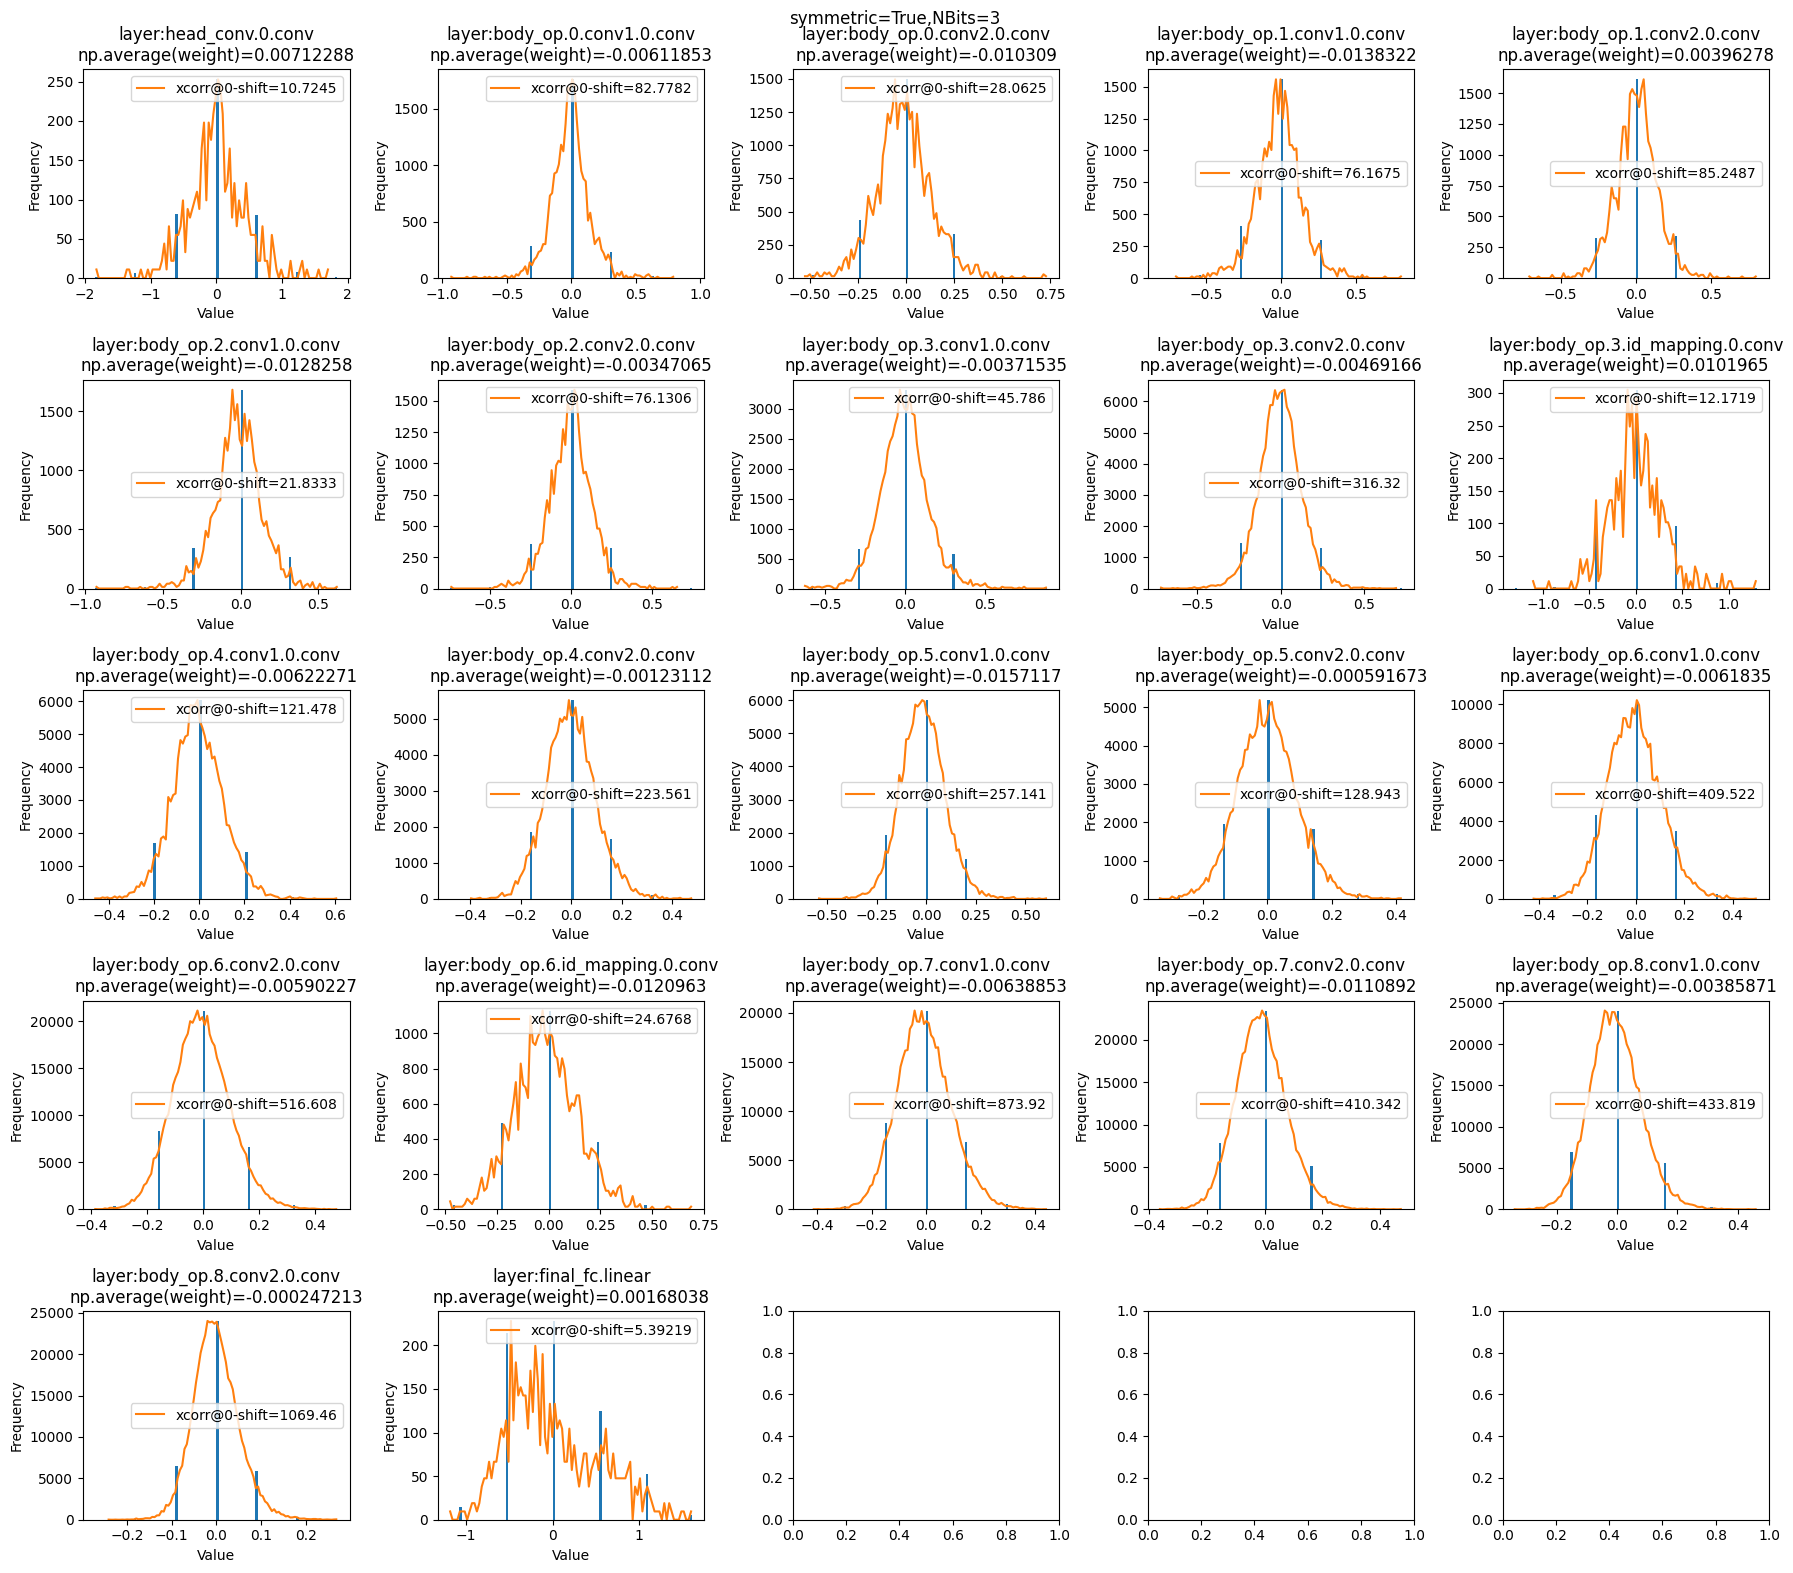

In [12]:
c_sym = plot_quant_symmetry(symmetric=True, save=True)

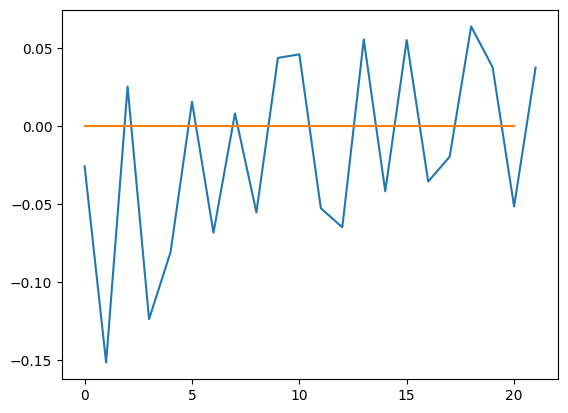

In [20]:
difference = np.array(c_asym) - np.array(c_sym)
plt.plot(0.5*difference / (np.array(c_asym) + np.array(c_sym)))
plt.plot([0, 20], [0, 0])